In [ ]:
!pip install torchsampler
!pip uninstall opencv-contrib-python opencv-python -y
!pip install opencv-python opencv-contrib-python

Found existing installation: opencv-python-headless 4.10.0.84
Uninstalling opencv-python-headless-4.10.0.84:
  Successfully uninstalled opencv-python-headless-4.10.0.84
Found existing installation: opencv-contrib-python 4.10.0.84
Uninstalling opencv-contrib-python-4.10.0.84:
  Successfully uninstalled opencv-contrib-python-4.10.0.84
Found existing installation: opencv-python 4.10.0.84
Uninstalling opencv-python-4.10.0.84:
  Successfully uninstalled opencv-python-4.10.0.84
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 MB 25.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import os,torch,cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import math
import json
import PIL
from torchvision import models
from skimage import io, util, color

cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

cuda


In [ ]:
annot_path = '/content/airplanes-dataset-for-rcnn/Airplanes_Annotations/Airplanes_Annotations'
img_path = '/content/airplanes-dataset-for-rcnn/Images/Images'

train_data_list = []
for file in os.listdir(img_path):
    if file.startswith('airplane'):
        train_data_list.append(file)

len(train_data_list)

700

In [ ]:

def get_iou(rect1,rect2):
    rect_area = lambda S: S[2]*S[3]
    rect1_x2 = rect1[0] + rect1[2]
    rect1_y2 = rect1[1] + rect1[3]
    rect2_x2 = rect2[0] + rect2[2]
    rect2_y2 = rect2[1] + rect2[3]
    inter_x1 = max(rect1[0],rect2[0])
    inter_y1 = max(rect1[1],rect2[1])
    inter_x2 = min(rect1_x2,rect2_x2)
    inter_y2 = min(rect1_y2,rect2_y2)
    if inter_x1>inter_x2 or inter_y1 >inter_y2:
        return 0
    S_rect1 = rect_area(rect1)
    S_rect2 = rect_area(rect2)
    S_inter = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
    S_U = S_rect1 + S_rect2 - S_inter
    IOU = S_inter/S_U
    assert IOU>=0
    assert IOU<=1.0
    return IOU

def get_SS(img_name):
    file_name = img_name.split('.')[0]
    img = io.imread((os.path.join(img_path,img_name)))
    if img.ndim == 2:    
        img = color.gray2rgb(img)
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    rects = rects.tolist()

    gtvalues = []
    
    data = pd.read_csv(os.path.join(annot_path,file_name+'.csv'))
    
    h = img.shape[0]
    w = img.shape[1]
    
    for _ in data.iloc[:,0]:
        x1 = int(_.split(' ')[0])
        y1 = int(_.split(' ')[1])
        _w = int(_.split(' ')[2]) - int(_.split(' ')[0])
        _h = int(_.split(' ')[3]) - int(_.split(' ')[1])
        gtvalues.append([x1,y1,_w,_h])
    
    pos_regions = []
    neg_regions = []
    n = 0
    for region in rects:
        for gtval1 in gtvalues:
            iou = get_iou(gtval1,region)
            if iou >= 0.1:
                rect = list(region)
                rect[0] = max(0, min(1, rect[0] / w))
                rect[1] = max(0, min(1, rect[1] / h))
                rect[2] = max(0, min(1, rect[0] + (rect[2] / w)))
                rect[3] = max(0, min(1, rect[1] + (rect[3] / h)))
                gtval = list(gtval1)
                gtval[0] = max(0, min(1, gtval[0] / w))
                gtval[1] = max(0, min(1, gtval[1] / h))
                gtval[2] = max(0, min(1, gtval[0] + (gtval[2] / w)))
                gtval[3] = max(0, min(1, gtval[1] + (gtval[3] / h)))
                assert all(x <= 1 for x in rect)
                assert all(x <= 1 for x in gtval)
                if iou >= 0.5:
                    pos_regions.append({
                        'rect':rect,
                        'gtval':gtval,
                        'label':1
                    })
                else:
                    neg_regions.append({
                        'rect':rect,
                        'gtval':gtval,
                        'label':0
                    })
    return pos_regions,neg_regions

In [ ]:
def split_list(input_list):
    n = len(input_list)
    part_80_length = n*0.8
    random.shuffle(input_list)
    part_80_length = int(part_80_length)
    part_80 = input_list[:part_80_length]
    part_20 = input_list[part_80_length:]
    return part_80, part_20

train_data,valid_data = split_list(train_data_list)

def create_data(data):
    if data == train_data:
        file_name = "train_data"
    elif data == valid_data:
        file_name = "valid_data"
    ss_regions = []
    for img_name in tqdm(data,desc=f'Creating {file_name}'):
        pos_regions,neg_regions = get_SS(img_name)
        ss_regions.append({
            'img_name':img_name,
            'pos_regions':pos_regions,
            'neg_regions':neg_regions
        })

    file_path = f"/content/working/{file_name}.json"
    with open(file_path, 'w') as f:
        json.dump(ss_regions, f)
    print(f'Creating {file_name} Successfully')
create_data(train_data)
create_data(valid_data)

Creating train_data: 100%|██████████| 560/560 [04:41<00:00,  1.99it/s]


Creating train_data Successfully


Creating valid_data: 100%|██████████| 140/140 [01:10<00:00,  1.98it/s]


Creating valid_data Successfully


In [6]:
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
with open('/content/working/train_data.json','r',encoding='utf-8') as f:
    ss_regions = json.load(f)
print(ss_regions[0])

{'img_name': 'airplane_553.jpg', 'pos_regions': [{'rect': [0.34375, 0.1875, 0.66015625, 0.40625], 'gtval': [0.33203125, 0.13671875, 0.69921875, 0.4921875], 'label': 1}, {'rect': [0.34375, 0.1640625, 0.6328125, 0.44921875], 'gtval': [0.33203125, 0.13671875, 0.69921875, 0.4921875], 'label': 1}, {'rect': [0.34375, 0.1875, 0.75, 0.40625], 'gtval': [0.33203125, 0.13671875, 0.69921875, 0.4921875], 'label': 1}, {'rect': [0.34375, 0.15625, 0.6796875, 0.47265625], 'gtval': [0.33203125, 0.13671875, 0.69921875, 0.4921875], 'label': 1}, {'rect': [0.33203125, 0.5390625, 0.7265625, 0.76171875], 'gtval': [0.28515625, 0.515625, 0.75, 0.890625], 'label': 1}, {'rect': [0.3515625, 0.18359375, 0.6796875, 0.3828125], 'gtval': [0.33203125, 0.13671875, 0.69921875, 0.4921875], 'label': 1}, {'rect': [0.2734375, 0, 0.70703125, 0.49609375], 'gtval': [0.33203125, 0.13671875, 0.69921875, 0.4921875], 'label': 1}, {'rect': [0.31640625, 0.49609375, 0.87890625, 0.8125], 'gtval': [0.28515625, 0.515625, 0.75, 0.890625],

In [ ]:
import torchvision.transforms.functional as TF

class Plane_Dataset(Dataset):
    def __init__(self,transform,dir='/kaggle/working/',mode='train'):
        assert mode in ['train', 'valid'], 'mode must be \'train\' or \'valid\''
        self.dir = dir
        self.mode = mode
        self.transform = transform
        with open(os.path.join(self.dir,'%s_data.json' %self.mode),'r',encoding='utf-8') as f:
            self.ss_regions = json.load(f)
        self.img_path = img_path

    def __len__(self):
        return len(self.ss_regions)

    def __getitem__(self,i, max_num_pos=16, max_num_neg=16):
        img = cv2.imread(os.path.join(self.img_path,self.ss_regions[i]['img_name']))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        img = PIL.Image.fromarray(img)
        img = img.resize((224,224))
        pos_regions = self.ss_regions[i]['pos_regions']
        neg_regions = self.ss_regions[i]['neg_regions']
        flipped_horizontally = False
        if self.transform is not None:
            original_img = img.copy()
            img = self.transform(img)
            original_img = valid_transform(original_img)
            if not torch.equal(img, original_img):
                flipped_horizontally = True         
                for region in pos_regions + neg_regions:
                    rect = region['rect']
                    gtval = region['gtval']
                    rect[0], rect[2] = 1 - rect[2], 1 - rect[0]
                    gtval[0], gtval[2] = 1 - gtval[2], 1 - gtval[0]

                
        if len(pos_regions) > max_num_pos:
            pos_regions = random.sample(pos_regions, max_num_pos)
        if len(neg_regions) > max_num_neg:
            neg_regions = random.sample(neg_regions, max_num_neg)

        regions = pos_regions + neg_regions
        random.shuffle(regions) 
        rects = [] 
        rela_locs = []  
        label = [] 
        for region in regions:
            rects.append(region['rect'])
            p_rect = region['rect']
            g_rect = region['gtval']
            t_x = (g_rect[0] + g_rect[2] - p_rect[0] - p_rect[2]) / 2 / (p_rect[2] - p_rect[0])
            t_y = (g_rect[1] + g_rect[3] - p_rect[1] - p_rect[3]) / 2 / (p_rect[3] - p_rect[1])
            t_w = math.log((g_rect[2] - g_rect[0]) / (p_rect[2] - p_rect[0]))
            t_h = math.log((g_rect[3] - g_rect[1]) / (p_rect[3] - p_rect[1]))
            rela_locs.append([t_x, t_y, t_w, t_h])
            label.append(region['label'])
        roi_idx_len = len(regions)
        return img, rects, roi_idx_len, rela_locs, label

train_dataset = Plane_Dataset(train_transform,dir='/kaggle/working/',mode='train')
valid_dataset = Plane_Dataset(valid_transform,dir='/kaggle/working/',mode='valid')

[[0, 0.5859375, 0.46875, 1], [0.48828125, 0.28515625, 0.76171875, 0.5234375], [0.484375, 0.28515625, 0.76171875, 0.57421875], [0.1796875, 0.1875, 0.640625, 0.69921875], [0.53515625, 0.28515625, 0.7734375, 0.50390625], [0.1171875, 0.40234375, 0.43359375, 0.7265625], [0.53515625, 0.26171875, 0.7734375, 0.50390625], [0, 0.13671875, 0.43359375, 0.68359375], [0.48828125, 0.1875, 0.7890625, 0.58203125], [0.1171875, 0.4453125, 0.43359375, 0.6953125], [0.53125, 0.25, 0.75390625, 0.58984375], [0, 0, 0.69921875, 0.7265625], [0.23828125, 0.46484375, 0.41015625, 0.5390625], [0.25, 0.5859375, 0.46875, 1], [0.078125, 0.3984375, 0.42578125, 0.72265625], [0, 0, 0.4609375, 0.75], [0.03125, 0.390625, 0.40234375, 0.7265625], [0.47265625, 0.25, 0.72265625, 0.5234375], [0.23828125, 0.515625, 0.43359375, 0.7265625], [0, 0.13671875, 0.43359375, 0.7265625], [0.1171875, 0.4453125, 0.43359375, 0.7265625], [0.1171875, 0.42578125, 0.40625, 0.73046875], [0.4765625, 0.1875, 0.7890625, 0.58203125], [0.62890625, 0.40

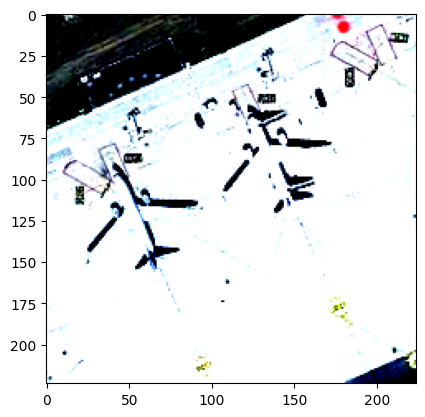

In [9]:
from PIL import Image, ImageDraw

# print(train_dataset.__len__())
# print(valid_dataset.__len__())
img, rects, roi_idx_len, rela_locs, cats = train_dataset.__getitem__(7)
print(rects,cats)

x1,y1,x2,y2 = rects[3]
x1 = int(x1*256)
x2 = int(x2*256)
y1 = int(y1*256)
y2 = int(y2*256)
r = random.randint(0, 256)
g = random.randint(0, 256)
b = random.randint(0, 256)
print(x1,y1,x2,y2)
# draw = ImageDraw.Draw(img)
# rectangle_coords = ((x1, y1), (x2, y2))
# draw.rectangle(rectangle_coords, fill=None, outline=(0, 0, 255), width=2)
img = torch.permute(img, (1, 2, 0))
plt.imshow(img)
plt.show()

In [ ]:
from torch import nn

class ROIPooling(nn.Module):
    def __init__(self,output_size):
        super().__init__()
        self.pool = nn.AdaptiveMaxPool2d(output_size)
        self.size = output_size

    def forward(self,imgs,rois,rois_idx):
        
        n = rois.shape[0] 
        h = imgs.shape[2] 
        w = imgs.shape[3] 

        x1 = rois[:, 0] 
        y1 = rois[:, 1] 
        x2 = rois[:, 2] 
        y2 = rois[:, 3] 

        x1 = np.floor(x1 * w).astype(int) 
        x2 = np.ceil(x2 * w).astype(int) 
        y1 = np.floor(y1 * h).astype(int)
        y2 = np.ceil(y2 * h).astype(int) 

        res = []
        for i in range(n):
            img = imgs[rois_idx[i]].unsqueeze(dim=0)
            img = img[:, :, y1[i]:y2[i], x1[i]:x2[i]]
            img = self.pool(img)
            res.append(img)
        res = torch.cat(res,dim=0)
        return res           

In [ ]:
class FastRCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        vgg = models.vgg16(weights=None)
        # vgg.classifier[-1] = nn.Linear(4096,2)
        # vgg.load_state_dict(torch.load('/content/plane_detection/pytorch/default/1/T_vgg_model (1).pt',weights_only=True))
        self.features = nn.Sequential(*list(vgg.features.children())[:-1])
        self.roipool = ROIPooling(output_size=(7, 7))
        self.output = nn.Sequential(*list(vgg.classifier.children())[:-1])
        self.prob = nn.Linear(4096, num_classes + 1)
        self.loc = nn.Linear(4096, 4 * (num_classes + 1))

        self.cat_loss = nn.CrossEntropyLoss()
        self.loc_loss = nn.SmoothL1Loss()

    def forward(self, img, rois, roi_idx):
        res = self.features(img)
        res = self.roipool(res, rois, roi_idx)
        res = res.view(res.shape[0], -1)
        features = self.output(res)
        prob = self.prob(features)
        loc = self.loc(features).view(-1, self.num_classes + 1, 4)
        return prob, loc

    def loss(self, prob, bbox, label, gt_bbox, lmb=1.0):
        loss_cat = self.cat_loss(prob, label)
        lbl = label.view(-1, 1, 1).expand(label.size(0), 1, 4)
        mask = (label != 0).float().view(-1, 1, 1).expand(label.shape[0], 1, 4)
        loss_loc = self.loc_loss(gt_bbox * mask, bbox.gather(1, lbl).squeeze(1) * mask)
        loss = loss_cat + lmb * loss_loc
        return loss, loss_cat, loss_loc

In [12]:
def train(train_data,model,optimizer):
    model.train()
    num_batches = len(train_dataset) // 64
    loss_all = 0
    loss_label_all = 0
    loss_loc_all = 0
    accuracy = 0
    num_samples = 0
    for i in range(num_batches):
        imgs = []
        rects = []
        roi_idxs = []
        rela_locs = []
        labels = []
        for j in range(64):
            img, rect, roi_idx_len, rela_loc, label = train_dataset[i *
                                                                 64+j]
            imgs.append(img.unsqueeze(0))
            rects += rect
            rela_locs += rela_loc
            roi_idxs += ([j] * roi_idx_len)   
            labels += label
        imgs = torch.cat(imgs, dim=0)
        rects = np.array(rects)
        rela_locs = torch.FloatTensor(rela_locs)
        labels = torch.LongTensor(labels)
        imgs = imgs.cuda()
        rela_locs = rela_locs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        prob, bbox = model.forward(imgs, rects, roi_idxs)
        loss, loss_label, loss_loc = model.loss(prob, bbox, labels, rela_locs)
        loss.backward()
        optimizer.step()
        num_samples += len(labels)
        loss_all += loss.item() * len(labels)
        loss_label_all += loss_label.item() * len(labels)
        loss_loc_all += loss_loc.item() * len(labels)
        accuracy += (torch.argmax(prob.detach(), dim=-1) == labels).sum().item()
    return model, loss_all/num_samples, loss_label_all/num_samples, loss_loc_all/num_samples, accuracy/num_samples

In [13]:
def valid(valid_data,model):
    model.eval()
    num_batches = len(train_dataset) // 64
    loss_all = 0
    loss_label_all = 0
    loss_loc_all = 0
    accuracy = 0
    num_samples = 0
    for i in range(num_batches):
        imgs = []
        rects = []
        roi_idxs = []
        rela_locs = []
        labels = []
        for j in range(64):
            img, rect, roi_idx_len, rela_loc, label = train_dataset[i *
                                                                 64+j]
            imgs.append(img.unsqueeze(0))
            rects += rect
            rela_locs += rela_loc
            roi_idxs += ([j] * roi_idx_len)   
            labels += label
        imgs = torch.cat(imgs, dim=0)

        rects = np.array(rects)
        rela_locs = torch.FloatTensor(rela_locs)
        labels = torch.LongTensor(labels)
        imgs = imgs.cuda()
        rela_locs = rela_locs.cuda()
        labels = labels.cuda()
        prob, bbox = model.forward(imgs, rects, roi_idxs)
        loss, loss_label, loss_loc = model.loss(prob, bbox, labels, rela_locs)
        num_samples += len(labels)
        loss_all += loss.item() * len(labels)
        loss_label_all += loss_label.item() * len(labels)
        loss_loc_all += loss_loc.item() * len(labels)
        accuracy += (torch.argmax(prob.detach(), dim=-1) == labels).sum().item()
    return model, loss_all/num_samples, loss_label_all/num_samples, loss_loc_all/num_samples, accuracy/num_samples

In [ ]:
epochs = 30

model = FastRCNN(1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-5)  
# def cosine_annealing_lr(epoch, T_max, lr_initial, lr_min=0):
#     lr = lr_min + (lr_initial - lr_min) * (1 + math.cos(math.pi * epoch / T_max)) / 2
#     return lr


model.cuda()
best_valid_loss = float('inf')

train_loss_list = []
train_loss_label_list = []
train_loss_loc_list = []
train_accuracy_list = []

valid_loss_list = []
valid_loss_label_list = []
valid_loss_loc_list = []
valid_accuracy_list = []

for epoch in range(epochs):
    print("Epoch %d:" % (epoch+1))
    # lr = cosine_annealing_lr(epoch, 30, lr_initial, lr_min)
    # for param_group in optimizer.param_groups:
    #     param_group['lr'] = lr
    model, train_loss, train_loss_label, train_loss_loc, train_accuracy = train(train_dataset,
        model, optimizer)
    train_loss_list.append(train_loss)
    train_loss_label_list.append(train_loss_label)
    train_loss_loc_list.append(train_loss_loc)
    train_accuracy_list.append(train_accuracy)
    print("Train: loss=%.4f, loss_label=%.4f, loss_loc=%.4f, accuracy=%.4f" %
          (train_loss, train_loss_label, train_loss_loc, train_accuracy))
    model, valid_loss, valid_loss_label, valid_loss_loc, valid_accuracy = valid(valid_dataset,
        model)
    valid_loss_list.append(valid_loss)
    valid_loss_label_list.append(valid_loss_label)
    valid_loss_loc_list.append(valid_loss_loc)
    valid_accuracy_list.append(valid_accuracy)
    print("Valid: loss=%.4f, loss_label=%.4f, loss_loc=%.4f, accuracy=%.4f" %
          (valid_loss, valid_loss_label, valid_loss_loc, valid_accuracy))
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        path = f'/content/working/FastRCNN.pt'
        torch.save(model.state_dict(),path)
        print("Model saved! New best validation loss: %.4f" % best_valid_loss)

Epoch 1:
Train: loss=0.7392, loss_label=0.6955, loss_loc=0.0437, accuracy=0.5176
Valid: loss=0.7278, loss_label=0.6849, loss_loc=0.0429, accuracy=0.6137
Model saved! New best validation loss: 0.7278
Epoch 2:
Train: loss=0.7076, loss_label=0.6651, loss_loc=0.0424, accuracy=0.6047
Valid: loss=0.6687, loss_label=0.6288, loss_loc=0.0398, accuracy=0.6352
Model saved! New best validation loss: 0.6687
Epoch 3:
Train: loss=0.6620, loss_label=0.6232, loss_loc=0.0389, accuracy=0.6443
Valid: loss=0.6478, loss_label=0.6113, loss_loc=0.0365, accuracy=0.6491
Model saved! New best validation loss: 0.6478
Epoch 4:
Train: loss=0.6361, loss_label=0.5999, loss_loc=0.0362, accuracy=0.6566
Valid: loss=0.6246, loss_label=0.5919, loss_loc=0.0327, accuracy=0.6732
Model saved! New best validation loss: 0.6246
Epoch 5:
Train: loss=0.6256, loss_label=0.5917, loss_loc=0.0339, accuracy=0.6680
Valid: loss=0.6048, loss_label=0.5748, loss_loc=0.0301, accuracy=0.6795
Model saved! New best validation loss: 0.6048
Epoch

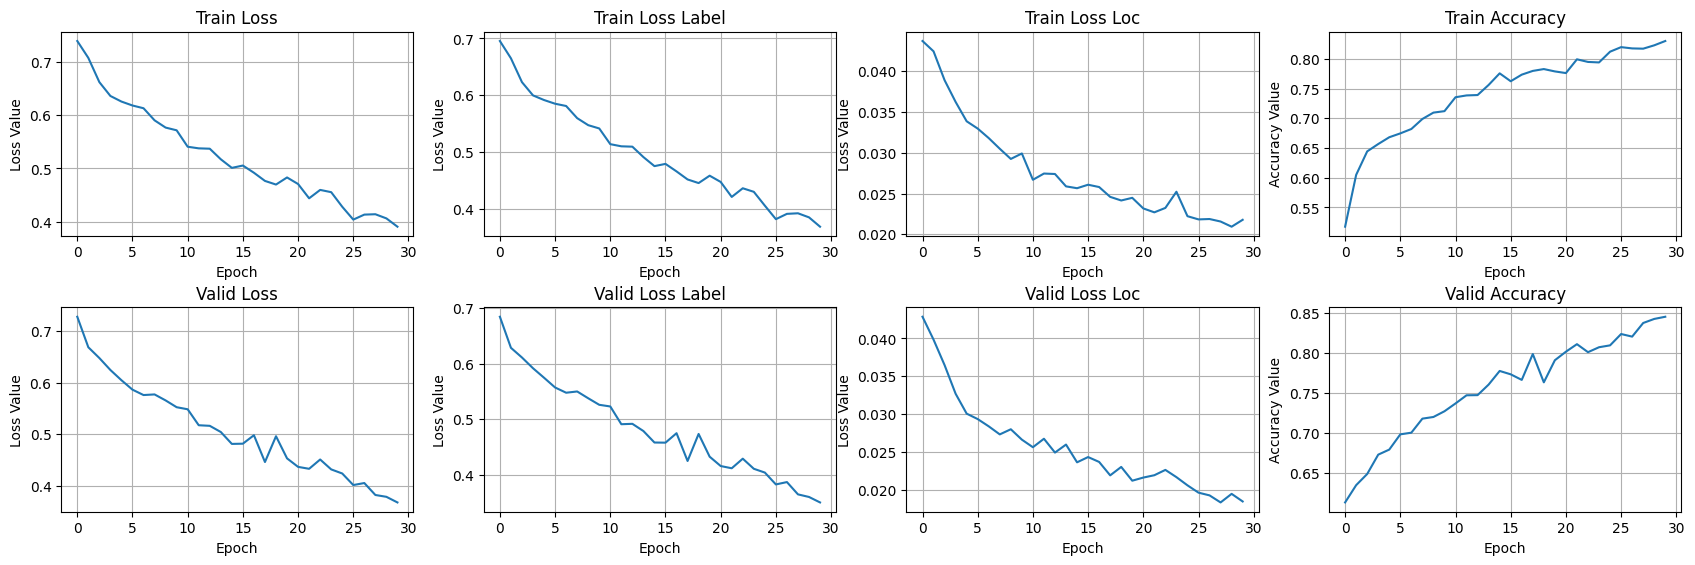

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(18, 6))


axes[0, 0].plot(train_loss_list)
axes[0, 0].set_title('Train Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss Value')
axes[0, 0].grid(True)

axes[0, 1].plot(train_loss_label_list)
axes[0, 1].set_title('Train Loss Label')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss Value')
axes[0, 1].grid(True)

axes[0, 2].plot(train_loss_loc_list)
axes[0, 2].set_title('Train Loss Loc')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss Value')
axes[0, 2].grid(True)

axes[0, 3].plot(train_accuracy_list)
axes[0, 3].set_title('Train Accuracy')
axes[0, 3].set_xlabel('Epoch')
axes[0, 3].set_ylabel('Accuracy Value')
axes[0, 3].grid(True)

axes[1, 0].plot(valid_loss_list)
axes[1, 0].set_title('Valid Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss Value')
axes[1, 0].grid(True)

axes[1, 1].plot(valid_loss_label_list)
axes[1, 1].set_title('Valid Loss Label')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss Value')
axes[1, 1].grid(True)

axes[1, 2].plot(valid_loss_loc_list)
axes[1, 2].set_title('Valid Loss Loc')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Loss Value')
axes[1, 2].grid(True)

axes[1, 3].plot(valid_accuracy_list)
axes[1, 3].set_title('Valid Accuracy')
axes[1, 3].set_xlabel('Epoch')
axes[1, 3].set_ylabel('Accuracy Value')
axes[1, 3].grid(True)

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.1, top=0.9, hspace=0.35, wspace=0.2)

plt.show()

In [ ]:
import torchvision

# trained_net = torch.load('/content/working/FastRCNN.pt', weights_only=True)
# model = FastRCNN(1)
# model.load_state_dict(trained_net)
model.cuda()

img = cv2.imread(img_path + '/428461.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

h, w = img.shape[:2]

ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ss_regions = ss.process()
rois = []

for region in ss_regions:
    rect = list(region)
    rect[0] = rect[0] / w
    rect[1] = rect[1] / h
    rect[2] = rect[0] + rect[2] / w
    rect[3] = rect[1] + rect[3] / h
    rois.append(rect)

rois = np.array(rois)
transform = valid_transform
img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0).cuda()

roi_idx = [0] * rois.shape[0]
prob, rela_loc = model.forward(img_tensor, rois, roi_idx)
prob = torch.nn.Softmax(dim=-1)(prob).cpu().detach().numpy()
rela_loc = rela_loc.cpu().detach().numpy()[:, 1:, :].mean(axis=1)

labels = []
max_probs = []
bboxs = []
r_bboxs = []

for i in range(len(prob)):
    if prob[i].max() > 0.85 and np.argmax(prob[i], axis=0)  != 0:
        bbox = [(rois[i][2] - rois[i][0]) * rela_loc[i][0] + 0.5 * (rois[i][2] + rois[i][0]),
                (rois[i][3] - rois[i][1]) * rela_loc[i][1] + 0.5 * (rois[i][3] + rois[i][1]),
                np.exp(rela_loc[i][2]) * rois[i][2],
                np.exp(rela_loc[i][3]) * rois[i][3]]
        labels.append(np.argmax(prob[i], axis=0))
        max_probs.append(prob[i].max())
        r_bboxs.append(bbox)
        rois[i] = [int(w * rois[i][0]), int(h * rois[i][1]),
                   int(w * rois[i][2]), int(h * rois[i][3])]
        bboxs.append(rois[i])
# print(bboxs)
print(len(bboxs))
print(max_probs)
labels = labels
# max_probs = np.array(max_probs)
# bboxs = np.array(bboxs).astype(int)
# r_bboxs = np.array(r_bboxs)

# order = np.argsort(-max_probs)
# print(order)
# labels = labels[order]
# max_probs = max_probs[order]
# bboxs = bboxs[order]
# r_bboxs = r_bboxs[order]


order = sorted(range(len(max_probs)), key=lambda k: max_probs[k], reverse=True)
keep = []
while len(order) > 0:
    i = order[0]
    keep.append(i)
    ious = []
    for j in order[1:]:
        iou = get_iou(bboxs[i], bboxs[j])
        ious.append(iou)
    order = [order[k] for k in range(1, len(order)) if ious[k-1] <= 0.3]

print(keep)

19
[0.864891, 0.93822753, 0.878482, 0.9392091, 0.9429105, 0.91949487, 0.9377629, 0.9377629, 0.87046415, 0.878482, 0.9359712, 0.931712, 0.87046415, 0.878482, 0.9392091, 0.878482, 0.91949487, 0.87046415, 0.878482]
[4, 3, 1, 6, 10, 5]


In [17]:
r_bboxs = np.array(r_bboxs)
r_bboxs = r_bboxs[keep]
r_bboxs = (r_bboxs*256).astype(int).tolist()
bboxs = np.array(bboxs)
bboxs = bboxs[keep]

[[ 92. 127. 116. 156.]
 [156.  52. 180.  94.]
 [175.  13. 208.  41.]
 [  0.  64.  20.  92.]
 [ 31.  73.  85. 101.]
 [ 53. 110.  78. 129.]]


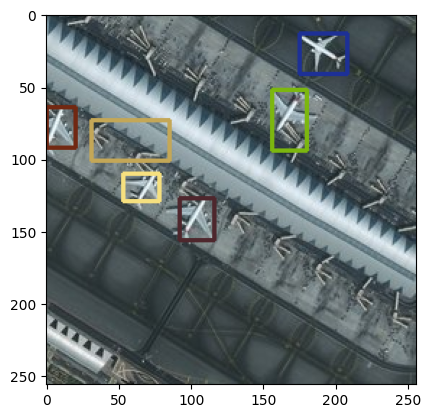

In [18]:
print(bboxs)
# print(r_bboxs)
for x1,y1,x2,y2 in bboxs:
    x1 = int(x1)
    x2 = int(x2)
    y1 = int(y1)
    y2 = int(y2)
    r = random.randint(0, 256)
    g = random.randint(0, 256)
    b = random.randint(0, 256)
    cv2.rectangle(img,(x1,y1),(x2,y2),(r,g,b),2)
# for x,y,w,h in r_bboxs:
#     x1 = int(x-w/2)
#     x2 = int(x+w/2)
#     y1 = int(y-h/2)
#     y2 = int(y+h/2)
#     print(x1,y1,x2,y2)
#     r = random.randint(0, 256)
#     g = random.randint(0, 256)
#     b = random.randint(0, 256)
#     cv2.rectangle(img,(x1,y1),(x2,y2),(r,g,b),2)
plt.imshow(img)